In [1]:
import numpy as np
import pandas as pd

In [2]:
from springtime.main import Workflow

In [3]:
recipe = "/home/jovyan/springtime/src/springtime/recipes/model_comparison_usecase.yaml"

In [4]:
Workflow.from_recipe(recipe).execute()

/tmp/data/rnpn/rnpn_npn_data_y_2015_Deciduous broadleaf_breaking leaf buds_Washington.csv already exists, skipping
/tmp/data/rnpn/rnpn_npn_data_y_2016_Deciduous broadleaf_breaking leaf buds_Washington.csv already exists, skipping
/tmp/data/rnpn/rnpn_npn_data_y_2017_Deciduous broadleaf_breaking leaf buds_Washington.csv already exists, skipping
/tmp/data/rnpn/rnpn_npn_data_y_2018_Deciduous broadleaf_breaking leaf buds_Washington.csv already exists, skipping
/tmp/data/rnpn/rnpn_npn_data_y_2019_Deciduous broadleaf_breaking leaf buds_Washington.csv already exists, skipping
/tmp/data/rnpn/rnpn_npn_data_y_2020_Deciduous broadleaf_breaking leaf buds_Washington.csv already exists, skipping


Dataset npn_obs loaded with 241 rows
Dataset npn_obs resampled to 241 rows


Dataset daymet loaded with 326310 rows
Dataset daymet resampled to 894 rows
Datesets joined to shape: (894, 25)
Data saved to: /tmp/output/data.csv


In [5]:
df = pd.read_csv("/tmp/output/data.csv")
df.head()

,year,geometry,breaking leaf buds_doy,tmin_1,tmin_2,tmin_3,tmin_4,tmin_5,tmin_6,tmin_7,...,tmax_3,tmax_4,tmax_5,tmax_6,tmax_7,tmax_8,tmax_9,tmax_10,tmax_11,tmax_12
0,2015,POINT (-122.357971 47.754948),50.0,3.81,5.000,5.59,4.640,10.19,11.625,14.50,...,14.26,14.620,18.91,24.785,25.74,25.52,19.165,17.60,9.450,7.37
1,2015,POINT (-122.377419 47.776241),50.0,3.68,4.955,5.56,4.585,10.11,11.540,14.41,...,14.25,14.635,18.96,24.765,25.73,25.58,19.165,17.60,9.475,7.41
2,2015,POINT (-122.185921 47.255966),56.0,3.27,4.915,5.66,4.920,9.83,11.760,14.66,...,14.04,14.070,18.19,25.545,26.81,26.20,18.965,16.63,9.120,6.62
3,2015,POINT (-121.861725 47.952686),50.0,1.93,3.440,4.21,2.920,9.24,10.015,12.76,...,13.13,13.765,17.79,24.680,25.72,25.52,18.025,15.80,7.835,5.09
4,2015,POINT (-122.686279 45.513168),99.0,3.70,5.290,6.23,4.825,9.91,12.530,14.75,...,17.13,15.765,21.45,28.005,29.36,28.66,22.720,19.08,10.715,8.00


In [6]:
df.dropna(inplace = True)
df.shape

(241, 27)

We have three matrices containing our n_samples =500 of training data:

X. Matrix containing three fixed effect features. Dimension = 500 x 3.
y. Vector containing the single target variable. Dimension = 500 x 1.
clusters. Vector containing the cluster_id for each sample. Dimension = 500 x1. We have k = 100 unique clusters in the training data.
In this example, there is not an explicit Z matrix. We create one to model a random mean for each cluster. It is a matrix of all 1s with dimension = 500 x 1.

In [7]:
y = df.pop("breaking leaf buds_doy")

In [8]:
# Z = df.pop("year")
# Z = Z.values[:,None]

df.drop(columns = ["year"], inplace = True)
Z = np.ones((len(y),1))

In [9]:
clusters = df.pop("geometry")

In [10]:
from sklearn.model_selection import train_test_split
indices = np.arange(len(y))
rand_num = 42
te_sz = 0.2
X_train, X_test, Z_train, Z_test, clusters_train, clusters_test, y_train, y_test, indices_train, indices_test = train_test_split(df, Z, clusters, y, indices, test_size=te_sz, random_state=rand_num)

In [11]:
print(X_train.shape)
print(Z_train.shape)
print(clusters_train.shape)
print(y_train.shape)

(192, 24)
(192, 1)
(192,)
(192,)


In [12]:
# Linear
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)
y_hat_lm = lm.predict(X_test)

In [13]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

In [14]:
print("Linear Regression Model")
print("mean_absolute_error: ", mean_absolute_error(y_test, y_hat_lm))
print("mean_squared_error: ", mean_squared_error(y_test, y_hat_lm))
print("r2: ", r2_score(y_test, y_hat_lm))

Linear Regression Model
mean_absolute_error:  44.82426405323358
mean_squared_error:  3197.151312171903
r2:  0.6247992212591051


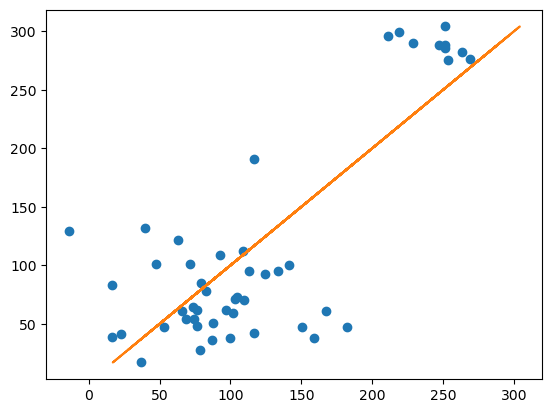

In [15]:
plt.plot(y_hat_lm, y_test, "o")
plt.plot(y_test, y_test, "-")

In [16]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_hat_rf = rf.predict(X_test)

In [17]:
print("RF Regression Model")
print("mean_absolute_error: ", mean_absolute_error(y_test, y_hat_rf))
print("mean_squared_error: ", mean_squared_error(y_test, y_hat_rf))
print("r2: ", r2_score(y_test, y_hat_rf))

RF Regression Model
mean_absolute_error:  26.097192714315163
mean_squared_error:  1683.3490930514713
r2:  0.8024510481561682


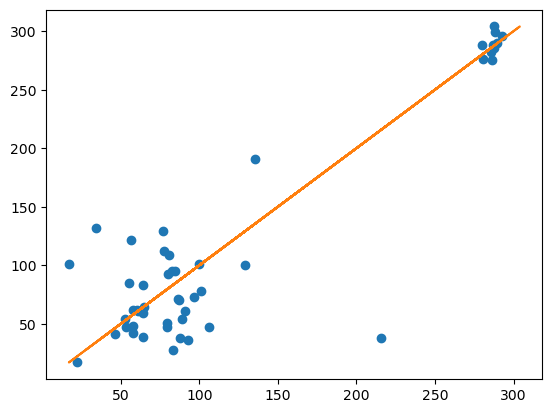

In [18]:
plt.plot(y_hat_rf, y_test, "o")
plt.plot(y_test, y_test, "-")

In [19]:
from interpret.glassbox import ExplainableBoostingRegressor
ebm = ExplainableBoostingRegressor()
ebm.fit(X_train, y_train)
y_hat_ebm = ebm.predict(X_test)

In [20]:
print("Linear Regression Model")
print("mean_absolute_error: ", mean_absolute_error(y_test, y_hat_ebm))
print("mean_squared_error: ", mean_squared_error(y_test, y_hat_ebm))
print("r2: ", r2_score(y_test, y_hat_ebm))

Linear Regression Model
mean_absolute_error:  29.88629211922297
mean_squared_error:  1710.5219336949328
r2:  0.799262187206355


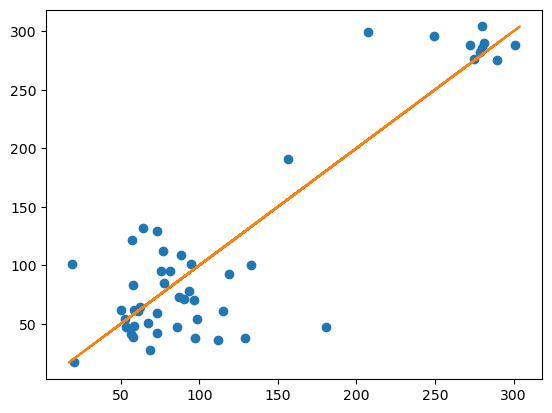

In [21]:
plt.plot(y_hat_ebm, y_test, "o")
plt.plot(y_test, y_test, "-")

In [22]:
from merf import MERF
merf = MERF()

In [23]:
merf.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf.py:307] Training GLL is 1763.3817123147687 at iteration 1.
INFO     [merf.py:307] Training GLL is 1870.6218704909504 at iteration 2.
INFO     [merf.py:307] Training GLL is 1907.8271937117267 at iteration 3.
INFO     [merf.py:307] Training GLL is 1917.7421474746807 at iteration 4.
INFO     [merf.py:307] Training GLL is 1940.1322305242377 at iteration 5.
INFO     [merf.py:307] Training GLL is 1954.298382232997 at iteration 6.
INFO     [merf.py:307] Training GLL is 1963.5869201183036 at iteration 7.
INFO     [merf.py:307] Training GLL is 1958.6200378598992 at iteration 8.
INFO     [merf.py:307] Training GLL is 1958.6875917054062 at iteration 9.
INFO     [merf.py:307] Training GLL is 1974.6210287979754 at iteration 10.
INFO     [merf.py:307] Training GLL is 1962.9141082223468 at iteration 11.
INFO     [merf.py:307] Training GLL is 1979.9544334991142 at iteration 12.
INFO     [merf.py:307] Training GLL is 1974.629933478824 at iteration 13.
INFO     [merf.py:307] Training GLL 

In [24]:
y_hat_merf = merf.predict(X_test, Z_test, clusters_test)

In [25]:
print("MERF Regression Model")
print("mean_absolute_error: ", mean_absolute_error(y_test, y_hat_merf))
print("mean_squared_error: ", mean_squared_error(y_test, y_hat_merf))
print("r2: ", r2_score(y_test, y_hat_merf))

MERF Regression Model
mean_absolute_error:  22.68994763980058
mean_squared_error:  1460.4859699626766
r2:  0.8286050862891772


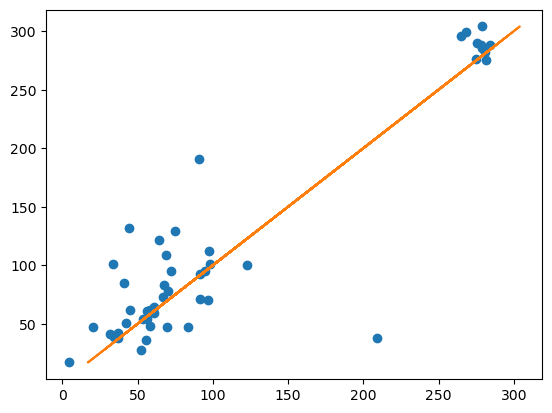

In [26]:
plt.plot(y_hat_merf, y_test, "o")
plt.plot(y_test, y_test, "-")

In [27]:
mrf_rf = MERF(rf)
mrf_rf.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf.py:307] Training GLL is 1756.0443098578774 at iteration 1.
INFO     [merf.py:307] Training GLL is 1870.6299808880237 at iteration 2.
INFO     [merf.py:307] Training GLL is 1912.2472198141095 at iteration 3.
INFO     [merf.py:307] Training GLL is 1929.4846161297685 at iteration 4.
INFO     [merf.py:307] Training GLL is 1950.4886212027704 at iteration 5.
INFO     [merf.py:307] Training GLL is 1965.556734921893 at iteration 6.
INFO     [merf.py:307] Training GLL is 1966.2954209093828 at iteration 7.
INFO     [merf.py:307] Training GLL is 1958.6409588405618 at iteration 8.
INFO     [merf.py:307] Training GLL is 1959.456316351379 at iteration 9.
INFO     [merf.py:307] Training GLL is 1980.5484296238556 at iteration 10.
INFO     [merf.py:307] Training GLL is 1974.6592953690306 at iteration 11.
INFO     [merf.py:307] Training GLL is 1972.7337181526273 at iteration 12.
INFO     [merf.py:307] Training GLL is 1972.2167235724894 at iteration 13.
INFO     [merf.py:307] Training GLL 

In [28]:
y_hat_merf_rf = mrf_rf.predict(X_test, Z_test, clusters_test)

In [29]:
print("MERF+RF Regression Model")
print("mean_absolute_error: ", mean_absolute_error(y_test, y_hat_merf_rf))
print("mean_squared_error: ", mean_squared_error(y_test, y_hat_merf_rf))
print("r2: ", r2_score(y_test, y_hat_merf_rf))

MERF+RF Regression Model
mean_absolute_error:  23.526416819017854
mean_squared_error:  1513.2422472646606
r2:  0.8224138884400743


In [30]:
mrf_lm = MERF(lm)
mrf_lm.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf.py:307] Training GLL is 2437.4899014848297 at iteration 1.
INFO     [merf.py:307] Training GLL is 2427.8988250485686 at iteration 2.
INFO     [merf.py:307] Training GLL is 2434.7665505313316 at iteration 3.
INFO     [merf.py:307] Training GLL is 2438.171820183171 at iteration 4.
INFO     [merf.py:307] Training GLL is 2440.0531107244506 at iteration 5.
INFO     [merf.py:307] Training GLL is 2441.3670563152627 at iteration 6.
INFO     [merf.py:307] Training GLL is 2442.47436043523 at iteration 7.
INFO     [merf.py:307] Training GLL is 2443.4993851274453 at iteration 8.
INFO     [merf.py:307] Training GLL is 2444.4805964485568 at iteration 9.
INFO     [merf.py:307] Training GLL is 2445.426522080128 at iteration 10.
INFO     [merf.py:307] Training GLL is 2446.335611113075 at iteration 11.
INFO     [merf.py:307] Training GLL is 2447.203061949204 at iteration 12.
INFO     [merf.py:307] Training GLL is 2448.0230791132976 at iteration 13.
INFO     [merf.py:307] Training GLL is 2

In [31]:
y_hat_merf_lm = mrf_lm.predict(X_test, Z_test, clusters_test)

In [32]:
print("MERF+LM Regression Model")
print("mean_absolute_error: ", mean_absolute_error(y_test, y_hat_merf_lm))
print("mean_squared_error: ", mean_squared_error(y_test, y_hat_merf_lm))
print("r2: ", r2_score(y_test, y_hat_merf_lm))

MERF+LM Regression Model
mean_absolute_error:  41.65389016189721
mean_squared_error:  2853.789317204953
r2:  0.6650943700720995


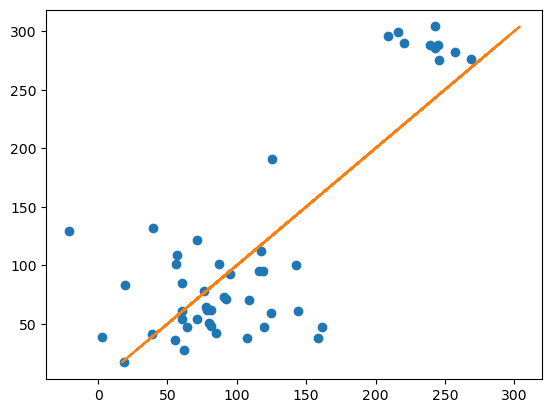

In [33]:
plt.plot(y_hat_merf_lm, y_test, "o")
plt.plot(y_test, y_test, "-")

In [34]:
mrf_ebm = MERF(ebm)
mrf_ebm.fit(X_train, Z_train, clusters_train, y_train)

INFO     [_binning.py:2584] Creating native dataset
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [_binning.py:2584] Creating native dataset
INFO     [ebm.py:702] Estimating with FAST
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [merf.py:307] Training GLL is 1729.2322117100189 at iteration 1.
INFO     [_binning.py:2584] Creating native dataset
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eval_terms
INFO     [_binning.py:2584] Creating native dataset
INFO     [ebm.py:702] Estimating with FAST
INFO     [bin.py:29] eval_terms
INFO     [bin.py:29] eva

In [35]:
y_hat_merf_ebm = mrf_ebm.predict(X_test, Z_test, clusters_test)

INFO     [bin.py:29] eval_terms


In [36]:
print("MERF+EBM Regression Model")
print("mean_absolute_error: ", mean_absolute_error(y_test, y_hat_merf_ebm))
print("mean_squared_error: ", mean_squared_error(y_test, y_hat_merf_ebm))
print("r2: ", r2_score(y_test, y_hat_merf_ebm))

MERF+EBM Regression Model
mean_absolute_error:  29.893672342605583
mean_squared_error:  1805.5081944718838
r2:  0.7881151017126167


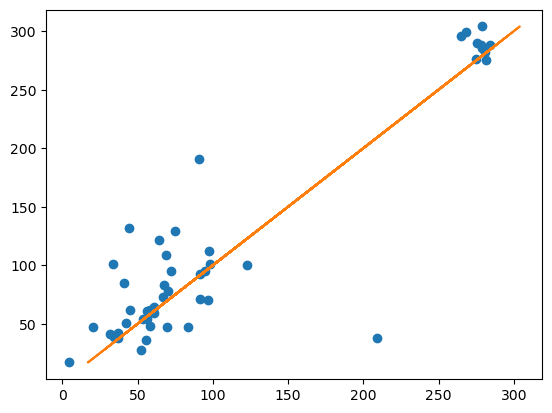

In [37]:
plt.plot(y_hat_merf, y_test, "o")
plt.plot(y_test, y_test, "-")

In [38]:
print("r2 summary:")
print("Linear: ", r2_score(y_test, y_hat_lm))
print("RF: ", r2_score(y_test, y_hat_rf))
print("EBM: ", r2_score(y_test, y_hat_ebm))
print("MERF: ", r2_score(y_test, y_hat_merf))
print("RF->MERF: ", r2_score(y_test, y_hat_merf_rf))
print("Linear->MERF: ", r2_score(y_test, y_hat_merf_lm))
print("EBM->MERF: ", r2_score(y_test, y_hat_merf_ebm))

r2 summary:
Linear:  0.6247992212591051
RF:  0.8024510481561682
EBM:  0.799262187206355
MERF:  0.8286050862891772
RF->MERF:  0.8224138884400743
Linear->MERF:  0.6650943700720995
EBM->MERF:  0.7881151017126167
